#### Вариант 12, Подопригорова Н, ИУ5-64б

#### Задание. 

Для заданного набора данных (по Вашему варианту) постройте модели классификации или регрессии (в зависимости от конкретной задачи, рассматриваемой в наборе данных). Для построения моделей используйте методы 1 и 2 (по варианту для Вашей группы). Оцените качество моделей на основе подходящих метрик качества (не менее двух метрик). Какие метрики качества Вы использовали и почему? Какие выводы Вы можете сделать о качестве построенных моделей? Для построения моделей необходимо выполнить требуемую предобработку данных: заполнение пропусков, кодирование категориальных признаков, и т.д.

Методы: Линейная/логистическая регрессия, Градиентный бустинг

In [1]:
import numpy as np
import pandas as pd
import math

import seaborn as sns
sns.set(style="ticks")

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error

In [90]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.001, a-0.05, str(round(b,3)), color='white')
        plt.show()  

In [53]:
data = pd.read_csv("dc-wikia-data.csv")

# Проведение разведочного анализа данных

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6896 entries, 0 to 6895
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   page_id           6896 non-null   int64  
 1   name              6896 non-null   object 
 2   urlslug           6896 non-null   object 
 3   ID                4883 non-null   object 
 4   ALIGN             6295 non-null   object 
 5   EYE               3268 non-null   object 
 6   HAIR              4622 non-null   object 
 7   SEX               6771 non-null   object 
 8   GSM               64 non-null     object 
 9   ALIVE             6893 non-null   object 
 10  APPEARANCES       6541 non-null   float64
 11  FIRST APPEARANCE  6827 non-null   object 
 12  YEAR              6827 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 700.5+ KB


Для заданного набора данных построим задачу регрессии и будем предсказывать количество появлений персонажей.

# Предобработка данных

Рассмотрим пропуски в числовых данных

In [11]:
total_count = data.shape[0]
num_cols = []
for col in data.columns:
    # Количество пустых значений 
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='float64' or dt=='int64'):
        num_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка APPEARANCES. Тип данных float64. Количество пустых значений 355, 5.15%.
Колонка YEAR. Тип данных float64. Количество пустых значений 69, 1.0%.


/Users/nonpenguin/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/nonpenguin/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


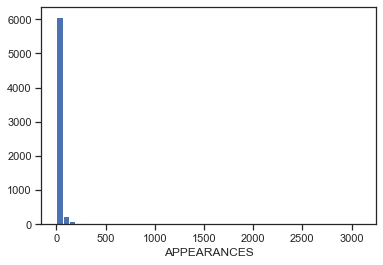

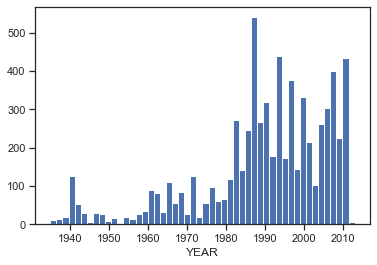

In [13]:
data_num = data[num_cols]
for col in data_num:
    plt.hist(data[col], 50)
    plt.xlabel(col)
    plt.show()

In [54]:
miss_mode_list = ['APPEARANCES']
for miss_mode in miss_mode_list:
    data[miss_mode] = data[miss_mode].fillna(data[miss_mode].mode()[0])

In [55]:
data['YEAR'] = data['YEAR'].fillna(data['YEAR'].median())

Рассмотрим пропуски в категориальных данных

In [10]:
cat_cols = []
for col in data.columns:
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='object'):
        cat_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка ID. Тип данных object. Количество пустых значений 2013, 29.19%.
Колонка ALIGN. Тип данных object. Количество пустых значений 601, 8.72%.
Колонка EYE. Тип данных object. Количество пустых значений 3628, 52.61%.
Колонка HAIR. Тип данных object. Количество пустых значений 2274, 32.98%.
Колонка SEX. Тип данных object. Количество пустых значений 125, 1.81%.
Колонка GSM. Тип данных object. Количество пустых значений 6832, 99.07%.
Колонка ALIVE. Тип данных object. Количество пустых значений 3, 0.04%.
Колонка FIRST APPEARANCE. Тип данных object. Количество пустых значений 69, 1.0%.


Мы можем заполнить SEX, ALIVE, ALIGN и FIRST APPEARANCE. Остальные признаки удалим, в них слишком много пропусков, да и значимыми они не кажутся.

In [56]:
miss = ['ID', 'SEX', 'ALIVE', 'ALIGN', 'FIRST APPEARANCE']

In [57]:
data[miss] = SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit_transform(data[miss])

In [58]:
data = data.drop(['GSM', 'EYE', 'HAIR'], axis = 1)

Закодируем категориальные данные

In [22]:
total_count = data.shape[0]
num_cols = []
for col in data.columns: 
    dt = str(data[col].dtype)
    if (dt=='object'):
        num_cols.append(col)        
        print('Колонка {}. Количество категорий: {}'.format(col, data[col].unique().shape[0]))

Колонка name. Количество категорий: 6896
Колонка urlslug. Количество категорий: 6896
Колонка ID. Количество категорий: 4
Колонка ALIGN. Количество категорий: 5
Колонка EYE. Количество категорий: 18
Колонка HAIR. Количество категорий: 18
Колонка SEX. Количество категорий: 5
Колонка ALIVE. Количество категорий: 3
Колонка FIRST APPEARANCE. Количество категорий: 775


Имя, ссылка на википедию, и месяц первого появления персонажа вряд ли помогут в предсказании количества появлений, так что удалим эти признаки.

Остальные закодируем OneHotEncoder

In [59]:
data = data.drop(['page_id', 'name', 'urlslug', 'FIRST APPEARANCE'], axis = 1)

In [60]:
categorical = ['ID','ALIGN', 'SEX', 'ALIVE']

data = pd.concat([data, pd.get_dummies(data[categorical], columns=categorical, drop_first=True)],axis=1)
data.drop(categorical, axis=1, inplace=True)

In [61]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
data[:] = min_max_scaler.fit_transform(data)

Рассмотрим корреляцию признаков с целевым и друг с другом и выберем полезные для построения модели.

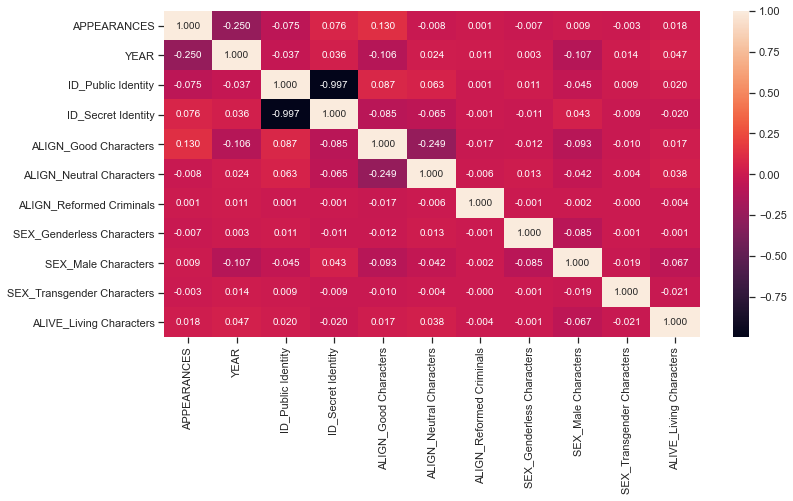

In [35]:
corrmat = data.corr()
plt.figure(figsize=(12,6))
sns.heatmap(corrmat, annot=True, fmt='.3f')

In [62]:
%%capture
y = data['APPEARANCES']
X = data[['YEAR', 'ID_Secret Identity', 'ALIGN_Good Characters', 'SEX_Male Characters', 'ALIVE_Living Characters']]

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)

Для оценки качества построенных моделей регрессии будем использовать метрики mean absolute error (чем ближе значение к нулю, тем лучше качество регрессии; метрика не нормирована), root mean squared error (сравнима с mae), median absolute error (устойчива к выбросам) и r2 score (чем ближе значение к единице, тем лучше качество регрессии).

In [91]:
metrics = MetricLogger()

# Линейная регрессия

In [68]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [92]:
y_pred_linear = model.predict(X_test)

RMSE = mean_squared_error(y_test, y_pred_linear, squared=False)
MAE = mean_absolute_error(y_test, y_pred_linear)
R2_Score = r2_score(y_test, y_pred_linear)
MedAE = median_absolute_error(y_test, y_pred_linear)

metrics.add('RMSE', 'Linear Regression', RMSE)
metrics.add('MAE', 'Linear Regression', MAE)
metrics.add('R2 Score', 'Linear Regression', R2_Score)
metrics.add('Median AE', 'Linear Regression', MedAE)

print('RMSE =', RMSE)
print('MAE =', MAE)
print('R2 Score =', R2_Score)
print ("Median AE =", MedAE)

RMSE = 0.021249986314018733
MAE = 0.008536167923128463
R2 Score = 0.11720132826370433
Median AE = 0.005169580097513711


# Градиентный бустинг

In [117]:
reg = GradientBoostingRegressor(learning_rate = 0.01, max_depth = 2, n_estimators= 250, random_state=0)
reg.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=2, n_estimators=250,
                          random_state=0)

In [118]:
boost_prediction = reg.predict(X_test)

In [119]:
RMSE = mean_squared_error(y_test, boost_prediction, squared=False)
MAE = mean_absolute_error(y_test, boost_prediction)
R2_Score = r2_score(y_test, boost_prediction)
MedAE = median_absolute_error(y_test, boost_prediction)

metrics.add('RMSE', 'Gradient Boosting', RMSE)
metrics.add('MAE', 'Gradient Boosting', MAE)
metrics.add('R2 Score', 'Gradient Boosting', R2_Score)
metrics.add('Median AE', 'Gradient Boosting', MedAE)

print('RMSE =', RMSE)
print('MAE =', MAE)
print('R2 Score =', R2_Score)
print ("Median AE =", MedAE)

RMSE = 0.021069081746936173
MAE = 0.007476969786341362
R2 Score = 0.13216816385504304
Median AE = 0.003360936331477969


# Выводы

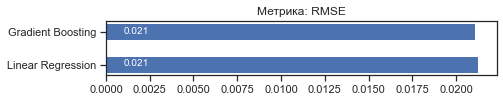

In [120]:
metrics.plot('Метрика: ' + 'RMSE', 'RMSE', ascending=False, figsize=(7, 1))

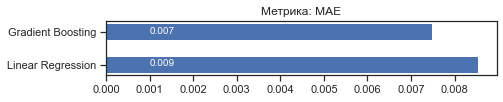

In [121]:
metrics.plot('Метрика: ' + 'MAE', 'MAE', ascending=False, figsize=(7, 1))

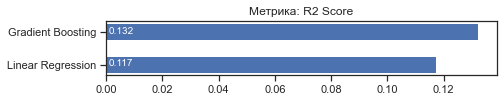

In [122]:
metrics.plot('Метрика: ' + 'R2 Score', 'R2 Score', ascending=True, figsize=(7, 1))

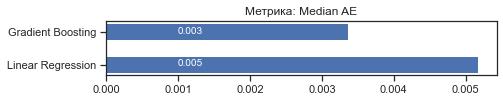

In [123]:
metrics.plot('Метрика: ' + 'Median AE', 'Median AE', ascending=False, figsize=(7, 1))

На основании всех четырёх метрик лучшей оказалась модель градиентного бустинга.